In [1]:
import pandas as pd
import numpy as np
import re
from urlextract import URLExtract
import matplotlib.pyplot as plt
import pickle 

from src.model_insights import get_word_covariance, get_class_features

extractor = URLExtract()

In [2]:
train_df = pd.read_csv('/Users/collinswestnedge/programming/Metis_Online/project_03/data/jigsaw-toxic-comment-classification-challenge/train.csv')
test_df_labels = pd.read_csv('/Users/collinswestnedge/programming/Metis_Online/project_03/data/jigsaw-toxic-comment-classification-challenge/test_labels.csv')
test_df = pd.read_csv('/Users/collinswestnedge/programming/Metis_Online/project_03/data/jigsaw-toxic-comment-classification-challenge/test.csv')

In [3]:
# replacing the -1 labels in test labels and 
# and joining it with the test.csv 
test_labels_temp = test_df_labels.replace(-1,np.nan)
test_labels_clean = test_labels_temp.dropna()
test_data = test_df.merge(test_labels_clean)

In [4]:
def preprocess(data):
    
    def replace_urls(x):
        urls = extractor.find_urls(x)
        if urls:
            x_new = replace_urls(x.replace(urls[0],''))
            return x_new
        else:
            return x

    data['comment_text'] = data.comment_text.map(lambda x: replace_urls(x))
    #get rid of duplicate letters just trying this out may comment out later
    data['comment_text'] = data.comment_text.map(lambda x: re.sub(r'(.)\1{2,}', '', str(x).lower()))
    # removing indents
    data['comment_text'] = data.comment_text.map(lambda x: re.sub('\\n',' ',str(x)))
    # remove weird user occurence 
    data['comment_text'] = data.comment_text.map(lambda x: re.sub("\[\[User.*",'',str(x)))
    # remove ip address
    data['comment_text'] = data.comment_text.map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    
    return data  

In [5]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

In [6]:
def get_metrics(classifier, X_train, y_train, X_test, y_test, plot_curve=False):
    
    
    '''
    Desription: calculate precision recall and f1 score and
    plot the roc curve for a model
    
    Parameters: classifier e.g. MultinomialNB()
    X_train y_train X_test y_test
    
    '''
    
    model = classifier
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    actuals = y_test
    
    print('-'*20 + ' ' + type(model).__name__  + ' ' + '-'*20)
        
    err_df = pd.DataFrame({'pred':preds, 'actual':actuals})

    TP = err_df.actual[(err_df.actual==1) & (err_df.pred==1)].count()
    print('TP: ', TP)
    # False Positives:
    FP = err_df.actual[(err_df.actual==0) & (err_df.pred==1)].count()
    print('FP: ', FP)
    # #True Negatives:
    TN = err_df.actual[(err_df.actual==0) & (err_df.pred==0)].count()
    print('TN: ', TN)
    #False Negatives:
    FN = err_df.actual[(err_df.actual==1) & (err_df.pred==0)].count()
    print('FN: ', FN)
    print()

    precision = TP/(TP+FP)
    recall =  TP/(TP+FN)
    print('Precision:', precision)
    print('Recall:', recall)
    print('Accuracy:', model.score(X_test, y_test))
    print('F1 Score:', 2*((precision*recall)/(precision+recall)))
    
    if plot_curve:
        print('Area Under ROC Curve:', roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
        fig, ax = plt.subplots(figsize=(6,4))
        test_disp = plot_roc_curve(model, X_test, y_test, ax=ax, color='red', linewidth=3)
        plt.show()

In [7]:
train_clean = preprocess(train_df)

In [8]:
test_clean = preprocess(test_data)

In [9]:
# ---------------------- playing with count vectorizer ------------------------

In [10]:
from nltk import RegexpTokenizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [11]:

# found where the difference between the highest coefficients for both classes was near zero.
# words like gay and wikipedia showed up which have a slight bias towards the toxic class. Decided to
# include some of these in the stop words list but ideally something like n_grams could better handle
# this issue if it didnt make my feature space explode.

new_stop_words = ['anything',
 'person',
 'day',
 'even',
 'wrong',
 'said',
 'personal',
 'message',
 'site',
 'vandalism',
 'thing',
 'keep',
 'right',
 'really',
 'know',
 'make',
 'back',
 'let',
 'put',
 'take',
 'better',
 'something',
 'mean',
 'say',
 'want',
 'never',
 'think',
 'fact',
 'time',
 'attack',
 'warning',
 'world',
 'blocked',
 'still',
 'got',
 'edits',
 'someone',
 'way',
 'people',
 'going',
 'well',
 'come',
 'user',
 'one',
 'like',
 'look',
 'change',
 'much',
 'good',
 'tell',
 'day',
 'even',
 'said',
 'vandalism',
 'thing',
 'keep',
 'right',
 'really',
 'know',
 'make',
 'back',
 'let',
 'put',
 'take',
 'better',
 'something',
 'mean',
 'say',
 'want',
 'think',
 'fact',
 'time',
 'blocked',
 'still',
 'edits',
 'someone',
 'way',
 'people',
 'going',
 'well',
 'word',
 'user',
 'one',
 'like',
 'look',
 'change',
 'much',
 'good',
 'comment',
 'read',
 'many',
 'reason',
 'sorry',
 'page',
 'need',
 'made',
 'edit',
 'place',
 'name',
 'block',
 'wikipedia',
 'wiki',
 'gay']



In [12]:
from nltk import RegexpTokenizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet


stop_words_complete = stopwords.words('english') + new_stop_words

# pickling stop words so i can do this in different notebook
# unfortunately pickling a class is hard so im going to have to
# copy paste the tokenizer class over 

with open('stop_words.pickle', 'wb') as file:
#     pickle.dump(my_tokenizer, file)
    pickle.dump(stop_words_complete, file)

    
# probably much better ways to do this
# but creating a tokenizer class to call in
# the TFDIF vectorizer 

class Tokenizer(object):
    def __init__(self):
        self.pt = PorterStemmer()
        self.wnl = WordNetLemmatizer()
        self.tk = RegexpTokenizer(r'\b[a-zA-Z]{3,}\b')
        self.stpwrd = set(stop_words_complete)
        
    def __call__(self, doc):
#         return [self.wnl.lemmatize(t, wordnet.VERB) for t in self.tk.tokenize(doc) if not t in self.stpwrd]
        return [self.wnl.lemmatize(t) for t in self.tk.tokenize(doc) if not t in self.stpwrd]


my_tokenizer = Tokenizer()

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression




In [17]:
# X, y = train_clean['comment_text'], train_clean['severe_toxic']
X, y = train_clean['comment_text'], train_clean['toxic']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=1)

vect = TfidfVectorizer(

                      lowercase = True,
                      token_pattern=None,
                      tokenizer=my_tokenizer,
                      ngram_range=(1, 1),
                      max_features=8000

                      )

X_train_vect = vect.fit_transform(X_train)
X_val_vect = vect.transform(X_val)

In [18]:
nb = MultinomialNB()
nb.fit(X_train_vect, y_train)
nb.score(X_val_vect, y_val)

0.9464515118282939

In [19]:


# logreg = LogisticRegression(random_state=1, solver='liblinear')

# parameters = {'penalty': ['l1', 'l2'],
#               'C':[0.001,.009,0.01,.09,1,5,10,25]}

# loggreg_grid = GridSearchCV(logreg, param_grid=parameters, scoring ='roc_auc', cv=5)
# loggreg_grid.fit(X_train_vect, y_train)

# print("Logistic Regression Accuracy:", loggreg_grid.best_score_)
# print("Logistic Regression (best parameters)", loggreg_grid.best_params_)

Logistic Regression Accuracy: 0.9439675264706873
Logistic Regression (best parameters) {'C': 1, 'penalty': 'l2'}


In [20]:
# log_reg = LogisticRegression(C=1, solver='liblinear', penalty='l2', random_state=1)
# log_reg.fit(X_train_vect, y_train)
# log_reg.score(X_val_vect, y_val)

0.9531881560394798

-------------------- LogisticRegression --------------------
TP:  1802
FP:  193
TN:  28619
FN:  1301

Precision: 0.9032581453634085
Recall: 0.5807283274250725
Accuracy: 0.9531881560394798
F1 Score: 0.7069438995684583
Area Under ROC Curve: 0.9469784875416027


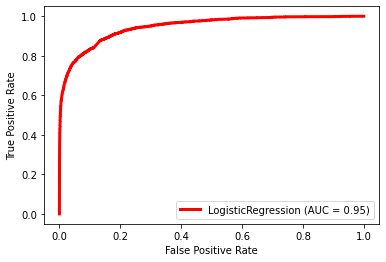

In [21]:
# get_metrics(LogisticRegression(C=1, solver='liblinear', penalty='l2', random_state=1), X_train_vect, y_train, X_val_vect, y_val, plot_curve=True)

In [ ]:
# with open('vectorizer.pickle', 'wb') as file:
#     # pickling vectorizer and vectorized data
#     pickle.dump(vect, file)
#     pickle.dump(X_train_vect, file)
#     pickle.dump(X_val_vect, file)
    
#     # pickling fitted model
#     pickle.dump(nb, file)

In [ ]:
get_metrics(MultinomialNB(), X_train_vect, y_train, X_val_vect, y_val, plot_curve=True)

In [ ]:
df, cov = get_word_covariance(vect, nb, n=5, top=True)
temp = df.reset_index()
filtered_temp = temp.sort_values(by=['toxic_coefs'], ascending=False)
filtered_temp

In [ ]:
df, cov = get_word_covariance(vect, nb, n=2000)
temp = df.reset_index()
filtered_temp = temp.sort_values(by=['non_toxic_coefs'], ascending=False)
filtered_temp

In [ ]:
# get highest coefficients for model
# sort dataframe by highest toxic coefficients and THEN
# look where coefficients have small difference for both labels
# and use this to create stop words

df, cov = get_word_covariance(vect, nb, n=100)
temp = df.reset_index()
filtered_temp = temp.sort_values(by=['toxic_coefs'], ascending=False)
filtered_temp = filtered_temp[(filtered_temp.non_toxic_coefs.notnull()) & (filtered_temp.toxic_coefs.notnull())].head(100).copy()
filtered_temp['coefficient_diff'] = (filtered_temp['non_toxic_coefs'] - filtered_temp['toxic_coefs'])**2
filtered_temp.sort_values(by=['coefficient_diff']).head(10)


In [ ]:
df, cov = get_word_covariance(vect, nb, n=100)
temp = df.reset_index()
filtered_temp = temp.sort_values(by=['non_toxic_coefs'], ascending=False)
filtered_temp = filtered_temp[(filtered_temp.non_toxic_coefs.notnull()) & (filtered_temp.toxic_coefs.notnull())].head(100).copy()
filtered_temp['coefficient_diff'] = (filtered_temp['non_toxic_coefs'] - filtered_temp['toxic_coefs'])**2
filtered_temp.sort_values(by=['coefficient_diff']).head(10)

In [ ]:
df = get_word_covariance(vect, nb, n=1000, top=False)
df

In [ ]:
# just doing some exploratory analysis with topic modeling here for own interest.

In [ ]:
from sklearn.decomposition import NMF

topics = 20
cols = ['topic' + str(i+1) for i in range(topics)]
nmf = NMF(n_components=topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(X_train_vect)

topic_df = pd.DataFrame(nmf.components_, index=cols, columns=vect.get_feature_names()).T

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

tfidf_feature_names = vect.get_feature_names()
n_top_words = 20
print_top_words(nmf, tfidf_feature_names, n_top_words)  

In [ ]:
neg, pos = get_class_features(vect, nb, n=10, top=True)
topic_formatted = topic_df.T[pos].T

In [ ]:
pos

In [ ]:
topic_formatted

In [ ]:
import seaborn as sns


def graph_topic(words,topic=[1,2]):
    topic_formatted = topic_df.T[words].T
    if len(topic) == 2:
        cols = ['topic'+str(val) for val in topic]
        plt.figure(figsize=[5,12])
        plt.barh(topic_formatted.index, topic_formatted[cols[0]])
        plt.barh(topic_formatted.index, topic_formatted[cols[1]])
    else:
        print('redo')
# plt.xticks(rotation=90);

In [ ]:
graph_topic(pos,[1,17])

In [ ]:
from sklearn.decomposition import TruncatedSVD, PCA

topics = 5
cols = ['topic' + str(i+1) for i in range(topics)]
svd = TruncatedSVD(n_components=topics)
lsa = svd.fit_transform(X_vect)
lsa_df = pd.DataFrame(lsa, columns=cols)
lsa_df['document'] = train_df['comment_text']
lsa_df['toxic'] = train_df.toxic
lsa_df

In [ ]:
# i think i may be indexing into these wrong look/fix later
neg, pos = get_class_features(vect, nb, n=20, top=True, indices=True)
lsa_df.iloc[neg]

In [ ]:
pd.DataFrame(svd.components_, index=cols, columns=vect.get_feature_names()).T

In [ ]:
# pca = PCA(2)
# X = pca.fit_transform(df)

In [ ]:
df, cov = get_word_covariance(vect, nb, n=1000, top=True)
# cov['hate'].sort_values(ascending=False).to_frame()
cov['please'].sort_values(ascending=False).to_frame()



In [ ]:
# ---- this is related to slides/showing context for high scoring words ------

In [123]:
doc = train_df[train_df['comment_text'].str.contains('nazi') & (train_df.toxic==1)].comment_text.values[1]

sub = '(\w*)\W*(\w*)\W*(\w*)\W*(\w*)\W*(\w*)\W*({})\W*(\w*)\W*(\w*)\W*(\w*)\W*(\w*)\W*(\w*)'.format('nazi')
str1 = doc
for i in re.findall(sub, str1, re.I):
    print (" ".join([x for x in i if x != ""]))

pair of jew hating weiner nazi schmucks


In [106]:
doc = train_df[train_df['comment_text'].str.contains('nazi')&(train_df.toxic==0)].comment_text.values[3]

sub = '(\w*)\W*(\w*)\W*(\w*)\W*(\w*)\W*({})\W*(\w*)\W*(\w*)\W*(\w*)\W*(\w*)\W*(\w*)'.format('nazi')
str1 = doc
for i in re.findall(sub, str1, re.I):
    print (" ".join([x for x in i if x != ""]))

member of the american nazi party 91 further evidence of
subcultures transversally as the nazi s did through a process


In [122]:
doc = train_df[train_df['comment_text'].str.contains('gay')&(train_df.toxic==1)].comment_text.values[1]

sub = '(\w*)\W*(\w*)\W*(\w*)\W*({})\W*(\w*)\W*(\w*)\W*(\w*)\W*(\w*)\W*(\w*)\W*(\w*)\W*(\w*)\W*(\w*)'.format('gay')
str1 = doc
for i in re.findall(sub, str1, re.I):
    print (" ".join([x for x in i if x != ""]))

fuck off u gay boy u r smelly fuck ur mum poopie


In [119]:
doc = train_df[train_df['comment_text'].str.contains('gay')&(train_df.toxic==0)].comment_text.values[16]

sub = '(\w*)\W*(\w*)\W*(\w*)\W*({})\W*(\w*)\W*(\w*)\W*(\w*)\W*(\w*)\W*(\w*)\W*(\w*)\W*(\w*)\W*(\w*)'.format('gay')
str1 = doc
for i in re.findall(sub, str1, re.I):
    print (" ".join([x for x in i if x != ""]))


the oppression of gay s and women the persecution of dissenting minorities


In [32]:
testing = train_df[train_df['comment_text'].str.contains('nazi') & (train_df.toxic==1)].comment_text.values[1]

print('-'*100)
tokenized_test = np.array(my_tokenizer(testing), dtype=np.object)
idx = np.where(tokenized_test=='nazi')[0]

if len(idx) > 0:
    for item in idx:
        if item > 0:
            print(tokenized_test[item-1])
        print(tokenized_test[item])
        if item < len(tokenized_test) -1:
            print(tokenized_test[item+1])


testing = train_df[train_df['comment_text'].str.contains('nazi')&(train_df.toxic==0)].comment_text.values[3]

print('-'*100)
tokenized_test = np.array(my_tokenizer(testing), dtype=np.object)
idx = np.where(tokenized_test=='nazi')[0]

if len(idx) > 0:
    for item in idx:
        if item > 0:
            print(tokenized_test[item-1])
        print(tokenized_test[item])
        if item < len(tokenized_test) -1:
            print(tokenized_test[item+1])


----------------------------------------------------------------------------------------------------
weiner
nazi
schmucks
----------------------------------------------------------------------------------------------------
american
nazi
party


In [ ]:
# ----- evaluating models on holdout ---------

-------------------- MultinomialNB --------------------
TP:  3526
FP:  1547
TN:  56341
FN:  2564

Precision: 0.6950522373349103
Recall: 0.5789819376026273
Accuracy: 0.935743536840789
F1 Score: 0.6317298217325091
Area Under ROC Curve: 0.9450324776409867


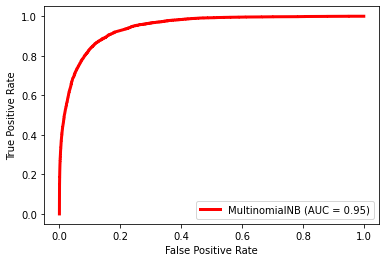

In [28]:
X_holdout = test_clean.comment_text
y_holdout = test_clean.toxic

vect = TfidfVectorizer(
                      lowercase = True,
                      token_pattern=None,
                      tokenizer=my_tokenizer,
                      ngram_range=(1, 1),
                      max_features=8000
                      )

X_train_vect = vect.fit_transform(X)
X_holdout_vect = vect.transform(X_holdout)

# nb = MultinomialNB()
# nb.fit(X_train_vect, y)
# nb.score(X_holdout_vect, y_holdout)

# pickling the vectorized data from training set so we can do 
# eda in another notebook
get_metrics(MultinomialNB(), X_train_vect, y, X_holdout_vect, y_holdout, plot_curve=True)

-------------------- LogisticRegression --------------------
TP:  4339
FP:  2481
TN:  55407
FN:  1751

Precision: 0.636217008797654
Recall: 0.7124794745484401
Accuracy: 0.9338522617149645
F1 Score: 0.6721920991479473
Area Under ROC Curve: 0.9559618437642112


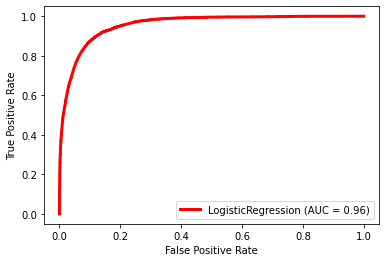

In [30]:
get_metrics(LogisticRegression(C=1, solver='liblinear', penalty='l2', random_state=1),
            X_train_vect, y, X_holdout_vect, y_holdout, plot_curve=True)




In [ ]:
# with open('vectorizer.pickle', 'wb') as file:
# #     pickling trained and vectorized data
#     pickle.dump(vect, file)
#     pickle.dump(X_train_vect, file)
#     pickle.dump(X_holdout_vect, file)
    
#     # pickling fitted model
#     pickle.dump(nb, file)

In [ ]:
get_metrics(MultinomialNB(), X_train_vect, y, X_holdout_vect, y_holdout, plot_curve=True)

In [ ]:
# ------- illustrating bias in our data for presentation ------

In [131]:
train_temp = train_df.copy()
train_temp['comment_lower'] = train_temp.comment_text.apply(lambda x : x.lower())

In [147]:
all_data = pd.concat([test_df, test_data])

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,NaN,NaN,NaN,NaN,NaN,NaN
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,NaN,NaN,NaN,NaN,NaN,NaN
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",NaN,NaN,NaN,NaN,NaN,NaN
3,00017563c3f7919a,":If you have a look back at the source, the in...",NaN,NaN,NaN,NaN,NaN,NaN
4,00017695ad8997eb,I don't anonymously edit articles at all.,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
63973,fff8f64043129fa2,":jerome, i see you never got around to this…! ...",0.0,0.0,0.0,0.0,0.0,0.0
63974,fff9d70fe0722906,==lucky bastard== heh you are famous now...,0.0,0.0,0.0,0.0,0.0,0.0
63975,fffa8a11c4378854,==shame on you all== you want to speak abou...,0.0,0.0,0.0,0.0,0.0,0.0
63976,fffac2a094c8e0e2,mel gibson is a nazi bitch who makes shitty mo...,1.0,0.0,1.0,0.0,1.0,0.0


In [165]:
totals = []
word_list = ['black', 'gay', 'muslim', 'jew','jewish', 'hispanic', 'mexican', 'lesbian', 'homosexual', 'feminism', 'feminist', 'transgender']
for item in word_list:
    toxic = train_temp[(train_temp.toxic==1)&(train_temp.comment_lower.str.contains(item))].shape[0]
    total = train_temp[train_temp.comment_text.str.contains(item)].shape[0]
    if toxic:
        totals.append([item, toxic/total])

In [166]:
df = pd.DataFrame(totals)
df.columns = ['word', 'percent labeled toxic']
df.sort_values(by=['percent labeled toxic'], ascending=False)

,word,percent labeled toxic
1,gay,0.548096
8,homosexual,0.383562
7,lesbian,0.303797
6,mexican,0.223776
11,transgender,0.206897
3,jew,0.162019
0,black,0.124219
10,feminist,0.118421
5,hispanic,0.115789
2,muslim,0.104839
